<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/LoughOwel_Summer(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 16.5 MB/s eta 0:00:00


In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import os # For checking file existence
from torchvision.transforms import ToTensor
from rasterio.plot import show

In [ ]:
RGB_FILE_PATH = '/ortho.tif'
NDVI_FILE_PATH = '/Loughowel_Site1_Summer_NDVI.tif'

In [ ]:
print(f"Loading: {RGB_FILE_PATH}")
print(f"Loading: {NDVI_FILE_PATH}")

Loading: /ortho.tif
Loading: /Loughowel_Site1_Summer_NDVI.tif


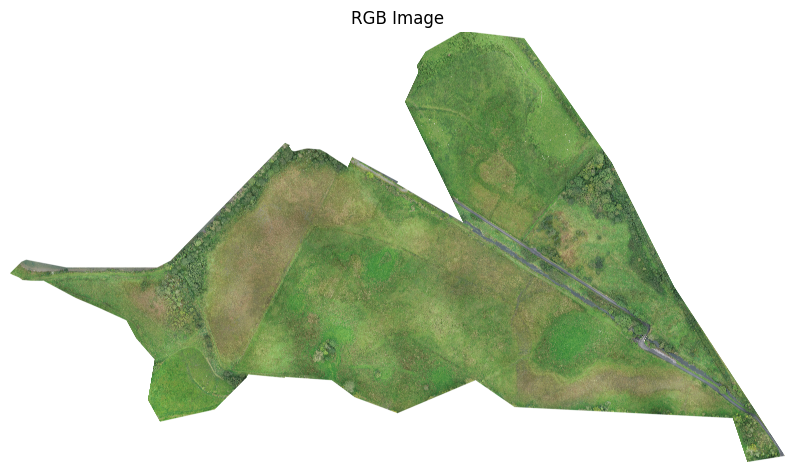

In [ ]:
#viewing rgb image

import matplotlib.pyplot as plt
import numpy as np
# Check if the RGB file exists before trying to open it
if os.path.exists(RGB_FILE_PATH):
    # Open the RGB file using rasterio
    with rasterio.open(RGB_FILE_PATH) as src:
        # Read the RGB image data
        rgb_image = src.read([1, 2, 3]) # Assuming the RGB bands are 1, 2, and 3

        # Transpose the image data to (height, width, channels) format
        rgb_image_display = np.transpose(rgb_image, (1, 2, 0))

        # Display the RGB image
        plt.figure(figsize=(10, 10))
        plt.imshow(rgb_image_display)
        plt.title("RGB Image")
        plt.axis('off')
        plt.show()

In [ ]:

image_path = '/Loughowel_Site1_Summer_NDVI.tif'
with rasterio.open(image_path) as src:
        print(f"Image shape: {src.shape}")
        print(f"Image CRS: {src.crs}")
        print(f"Image bounds: {src.bounds}")
        print(f"Image transform: {src.transform}")


Image shape: (12310, 17025)
Image CRS: EPSG:2157
Image bounds: BoundingBox(left=641802.6031360056, bottom=756023.9738621777, right=642515.9567291917, top=756539.7955408848)
Image transform: | 0.04, 0.00, 641802.60|
| 0.00,-0.04, 756539.80|
| 0.00, 0.00, 1.00|


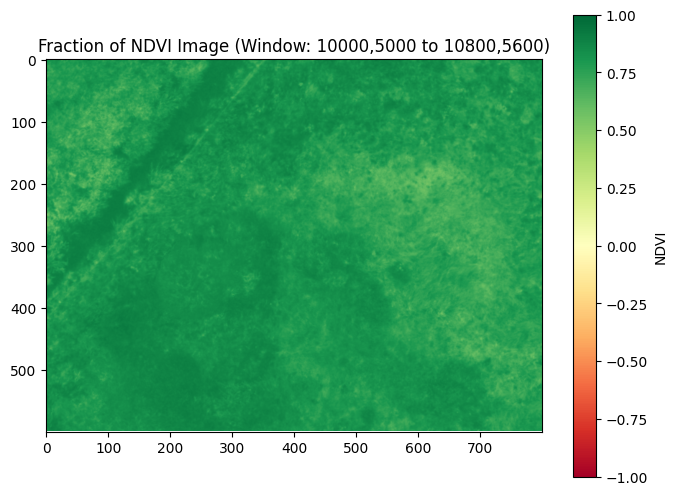

Shape of loaded fraction: (600, 800)


In [ ]:
import rasterio
from rasterio.windows import Window
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np

image_path = '/Loughowel_Site1_Summer_NDVI.tif'

# Define a window by pixel coordinates ---
# For example, pixels from (col_start, row_start) to (col_end, row_end)
col_start = 10000
row_start = 5000
width = 800  # Number of pixels wide
height = 600 # Number of pixels high

with rasterio.open(image_path) as src:
        # Read a specific window of the image
        window = Window(col_start, row_start, width, height)
        fraction_data = src.read(1, window=window) # Read band 1 (NDVI usually single-band)

        # Plotting the fraction
        plt.figure(figsize=(8, 6))
        plt.imshow(fraction_data, cmap='RdYlGn', vmin=-1, vmax=1) # Appropriate colormap for NDVI
        plt.colorbar(label='NDVI')
        plt.title(f'Fraction of NDVI Image (Window: {col_start},{row_start} to {col_start+width},{row_start+height})')
        plt.show()
        print(f"Shape of loaded fraction: {fraction_data.shape}")


In [ ]:
with rasterio.open(NDVI_FILE_PATH) as src_ndvi:
            ndvi_data = src_ndvi.read(1) # Read the single NDVI band

            # Handle NoData values (replace with NaN for correct statistics)
            if src_ndvi.nodata is not None:
                ndvi_data = np.where(ndvi_data == src_ndvi.nodata, np.nan, ndvi_data)

            # Calculate statistics, ignoring NaN values
            min_ndvi = np.nanmin(ndvi_data)
            max_ndvi = np.nanmax(ndvi_data)
            mean_ndvi = np.nanmean(ndvi_data)
            std_ndvi = np.nanstd(ndvi_data)
            median_ndvi = np.nanmedian(ndvi_data)

            print(f"NDVI Statistics for {NDVI_FILE_PATH}:")
            print(f"  Min: {min_ndvi:.3f}")
            print(f"  Max: {max_ndvi:.3f}")
            print(f"  Mean: {mean_ndvi:.3f}")
            print(f"  Standard Deviation: {std_ndvi:.3f}")
            print(f"  Median: {median_ndvi:.3f}")

            # calculate percentiles
            p10 = np.nanpercentile(ndvi_data, 10)
            p90 = np.nanpercentile(ndvi_data, 90)
            print(f"  10th Percentile: {p10:.3f}")
            print(f"  90th Percentile: {p90:.3f}")


NDVI Statistics for /Loughowel_Site1_Summer_NDVI.tif:
  Min: -0.112
  Max: 0.962
  Mean: 0.805
  Standard Deviation: 0.075
  Median: 0.817
  10th Percentile: 0.740
  90th Percentile: 0.871


In [ ]:
if ndvi_data is not None:
    # Define NDVI thresholds for Lough Owel Site 1 based on statistical outputs.

    NON_VEGETATED_THRESHOLD = 0.15      # Includes water, bare soil, very low vigor (e.g., Min: -0.112)
    SPARSE_VEG_THRESHOLD = 0.3          # Areas with some sparse cover or stressed vegetation
    MODERATE_VEG_THRESHOLD = 0.6        # Mid-range vegetation, e.g., grasslands, mixed areas
    HEALTHY_VEG_THRESHOLD = 0.8         # Good, thriving vegetation (around your 10th percentile 0.740)

    # Create a classified array, initializing with NaN for areas that are not classified
    classified_ndvi = np.full(ndvi_data.shape, np.nan, dtype=np.uint8) # Use uint8 for categories

    # Apply classification rules
    # Category 1: Non-Vegetated/Very Low Vigor
    classified_ndvi[ndvi_data <= NON_VEGETATED_THRESHOLD] = 1
    # Category 2: Sparse/Poor Vegetation
    classified_ndvi[(ndvi_data > NON_VEGETATED_THRESHOLD) & (ndvi_data <= SPARSE_VEG_THRESHOLD)] = 2
    # Category 3: Moderate Vegetation
    classified_ndvi[(ndvi_data > SPARSE_VEG_THRESHOLD) & (ndvi_data <= MODERATE_VEG_THRESHOLD)] = 3
    # Category 4: Healthy Vegetation
    classified_ndvi[(ndvi_data > MODERATE_VEG_THRESHOLD) & (ndvi_data <= HEALTHY_VEG_THRESHOLD)] = 4
    # Category 5: Very Healthy/Lush Vegetation
    classified_ndvi[ndvi_data > HEALTHY_VEG_THRESHOLD] = 5

    print("\nVegetation Health Categories Defined:")
    print(f"  1: Non-Vegetated/Very Low Vigor (NDVI <= {NON_VEGETATED_THRESHOLD})")
    print(f"  2: Sparse/Poor Vegetation ({NON_VEGETATED_THRESHOLD} < NDVI <= {SPARSE_VEG_THRESHOLD})")
    print(f"  3: Moderate Vegetation ({SPARSE_VEG_THRESHOLD} < NDVI <= {MODERATE_VEG_THRESHOLD})")
    print(f"  4: Healthy Vegetation ({MODERATE_VEG_THRESHOLD} < NDVI <= {HEALTHY_VEG_THRESHOLD})")
    print(f"  5: Very Healthy/Lush Vegetation (NDVI > {HEALTHY_VEG_THRESHOLD})")

/usr/local/lib/python3.11/dist-packages/numpy/_core/numeric.py:362: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')



Vegetation Health Categories Defined:
  1: Non-Vegetated/Very Low Vigor (NDVI <= 0.15)
  2: Sparse/Poor Vegetation (0.15 < NDVI <= 0.3)
  3: Moderate Vegetation (0.3 < NDVI <= 0.6)
  4: Healthy Vegetation (0.6 < NDVI <= 0.8)
  5: Very Healthy/Lush Vegetation (NDVI > 0.8)


In [ ]:
if ndvi_data is not None:
    # --- Get unique categories and their counts ---
    # np.unique with return_counts=True gives unique values and how many times they appear.
    #  filter out NaN values before counting to only include classified pixels.
    unique_categories, counts = np.unique(classified_ndvi[~np.isnan(classified_ndvi)], return_counts=True)
    category_counts = dict(zip(unique_categories, counts))

    # Calculate the total number of pixels that were actually classified (not NaN)
    total_classified_pixels = np.nansum(counts)

    print("\nPixel Counts by Category:")
    # Define a dictionary to map category IDs to human-readable names
    category_names = {

        1: "Non-Vegetated/Very Low Vigor",
        2: "Sparse/Poor Vegetation",
        3: "Moderate Vegetation",
        4: "Healthy Vegetation",
        5: "Very Healthy/Lush Vegetation"
    }

    # Iterate through the sorted category IDs to print results consistently
    for category_id in sorted(category_counts.keys()):
        count = category_counts[category_id]
        # Calculate percentage, handling division by zero if no pixels were classified
        percentage = (count / total_classified_pixels) * 100 if total_classified_pixels > 0 else 0
        # Get the descriptive name for the category, or a fallback if not found
        name = category_names.get(category_id, f"Unknown Category {int(category_id)}")
        print(f"  {name}: {int(count)} pixels ({percentage:.2f}%)")

else:
    print("Classification skipped because NDVI data could not be loaded.")


Pixel Counts by Category:
  Unknown Category 0: 106678972 pixels (50.90%)
  Non-Vegetated/Very Low Vigor: 6155 pixels (0.00%)
  Sparse/Poor Vegetation: 193300 pixels (0.09%)
  Moderate Vegetation: 1743306 pixels (0.83%)
  Healthy Vegetation: 36198599 pixels (17.27%)
  Very Healthy/Lush Vegetation: 64757418 pixels (30.90%)


In [ ]:

import numpy as np
if ndvi_data is not None:
    # Get the minimum and maximum NDVI values from the data
    min_ndvi_data = np.nanmin(ndvi_data)
    max_ndvi_data = np.nanmax(ndvi_data)

    print(f"\nReviewing NDVI thresholds against data range ({min_ndvi_data:.3f} to {max_ndvi_data:.3f}):")

    # Check if the lowest threshold is within the data range or below the minimum
    if NON_VEGETATED_THRESHOLD < min_ndvi_data:
        print(f"  Warning: Lowest threshold ({NON_VEGETATED_THRESHOLD:.3f}) is higher than the minimum NDVI in data ({min_ndvi_data:.3f}). Pixels below the threshold will be unclassified unless they are NoData.")
    else:
         print(f"  Lowest threshold ({NON_VEGETATED_THRESHOLD:.3f}) is appropriate relative to minimum NDVI ({min_ndvi_data:.3f}).")


    # Check if the highest threshold covers the maximum value
    if HEALTHY_VEG_THRESHOLD < max_ndvi_data:
        print(f"  Highest threshold ({HEALTHY_VEG_THRESHOLD:.3f}) is lower than the maximum NDVI in data ({max_ndvi_data:.3f}). Pixels above this threshold are assigned to the highest category (5).")
    else:
         print(f"  Highest threshold ({HEALTHY_VEG_THRESHOLD:.3f}) covers the maximum NDVI ({max_ndvi_data:.3f}).")

    # Optionally, check if there are gaps between thresholds (though this setup doesn't create gaps)
    # Check threshold ordering
    if not (NON_VEGETATED_THRESHOLD <= SPARSE_VEG_THRESHOLD <= MODERATE_VEG_THRESHOLD <= HEALTHY_VEG_THRESHOLD):
        print("  Error: NDVI thresholds are not in increasing order.")
    else:
        print("  Thresholds are in increasing order.")

    # Display the defined thresholds
    print("\nDefined NDVI Thresholds:")
    print(f"  Non-Vegetated/Very Low Vigor (Category 1): NDVI <= {NON_VEGETATED_THRESHOLD}")
    print(f"  Sparse/Poor Vegetation (Category 2): {NON_VEGETATED_THRESHOLD} < NDVI <= {SPARSE_VEG_THRESHOLD}")
    print(f"  Moderate Vegetation (Category 3): {SPARSE_VEG_THRESHOLD} < NDVI <= {MODERATE_VEG_THRESHOLD}")
    print(f"  Healthy Vegetation (Category 4): {MODERATE_VEG_THRESHOLD} < NDVI <= {HEALTHY_VEG_THRESHOLD}")
    print(f"  Very Healthy/Lush Vegetation (Category 5): NDVI > {HEALTHY_VEG_THRESHOLD}")

else:
    print("NDVI data not available for threshold review.")



Reviewing NDVI thresholds against data range (-0.112 to 0.962):
  Lowest threshold (0.150) is appropriate relative to minimum NDVI (-0.112).
  Highest threshold (0.800) is lower than the maximum NDVI in data (0.962). Pixels above this threshold are assigned to the highest category (5).
  Thresholds are in increasing order.

Defined NDVI Thresholds:
  Non-Vegetated/Very Low Vigor (Category 1): NDVI <= 0.15
  Sparse/Poor Vegetation (Category 2): 0.15 < NDVI <= 0.3
  Moderate Vegetation (Category 3): 0.3 < NDVI <= 0.6
  Healthy Vegetation (Category 4): 0.6 < NDVI <= 0.8
  Very Healthy/Lush Vegetation (Category 5): NDVI > 0.8


In [ ]:
# prompt: create the classified_ndvi_masked variable by masking background

import numpy as np
if ndvi_data is not None:
    # Use the original NDVI data's NoData value for the masked output

    nodata_value = src_ndvi.nodata if src_ndvi.nodata is not None else 0

    # Create a masked array where areas with original NoData in ndvi_data (which we converted to NaN)
    # are masked out.
    classified_ndvi_masked = np.ma.masked_where(np.isnan(ndvi_data), classified_ndvi)

    # Alternatively, to create an array with a specific fill value for masked areas:
    # classified_ndvi_masked = np.nan_to_num(classified_ndvi, nan=nodata_value).astype(np.uint8)

    print("\nCreated 'classified_ndvi_masked' variable.")
    print("Shape of masked classification:", classified_ndvi_masked.shape)
    # Check if it's a masked array and show mask status
    print("Is a masked array:", isinstance(classified_ndvi_masked, np.ma.MaskedArray))
    if isinstance(classified_ndvi_masked, np.ma.MaskedArray):
        print("Number of masked pixels:", np.ma.count_masked(classified_ndvi_masked))
        print("Number of unmasked pixels:", np.ma.count(classified_ndvi_masked))
else:
    print("Could not create 'classified_ndvi_masked' because NDVI data was not loaded.")


Created 'classified_ndvi_masked' variable.
Shape of masked classification: (12310, 17025)
Is a masked array: True
Number of masked pixels: 106678972
Number of unmasked pixels: 102898778


In [ ]:
# prompt: perform your pixel counting and percentage calculations only on the unmasked elements.

import numpy as np
if ndvi_data is not None:
    # Create a boolean mask for the unmasked elements in the original NDVI data.
    # We converted NoData values to NaN, so we check for not NaN.
    unmasked_mask = ~np.isnan(ndvi_data)

    # Apply this mask to the classified data to get only the pixels that were not originally NoData.
    classified_unmasked = classified_ndvi[unmasked_mask]

    # --- Get unique categories and their counts from the UNMASKED data ---
    # np.unique with return_counts=True gives unique values and how many times they appear.
    unique_categories_unmasked, counts_unmasked = np.unique(classified_unmasked, return_counts=True)
    category_counts_unmasked = dict(zip(unique_categories_unmasked, counts_unmasked))

    # Calculate the total number of pixels that are unmasked (and thus classified)
    total_unmasked_pixels = np.sum(unmasked_mask) # This should be equal to np.sum(counts_unmasked)

    print("\nPixel Counts by Category (Unmasked Data Only):")
    # Define a dictionary to map category IDs to human-readable names
    category_names = {
        1: "Non-Vegetated/Very Low Vigor",
        2: "Sparse/Poor Vegetation",
        3: "Moderate Vegetation",
        4: "Healthy Vegetation",
        5: "Very Healthy/Lush Vegetation"
    }

    # Iterate through the sorted category IDs to print results consistently
    # Use category_counts_unmasked keys
    for category_id in sorted(category_counts_unmasked.keys()):
        count = category_counts_unmasked[category_id]
        # Calculate percentage relative to the total number of unmasked pixels
        percentage = (count / total_unmasked_pixels) * 100 if total_unmasked_pixels > 0 else 0
        # Get the descriptive name for the category, or a fallback if not found
        name = category_names.get(category_id, f"Unknown Category {int(category_id)}")
        print(f"  {name}: {int(count)} pixels ({percentage:.2f}%)")

    # Print the total number of unmasked pixels
    print(f"Total unmasked and classified pixels: {total_unmasked_pixels}")

else:
    print("Pixel counting and percentage calculations skipped because NDVI data could not be loaded.")



Pixel Counts by Category (Unmasked Data Only):
  Non-Vegetated/Very Low Vigor: 6155 pixels (0.01%)
  Sparse/Poor Vegetation: 193300 pixels (0.19%)
  Moderate Vegetation: 1743306 pixels (1.69%)
  Healthy Vegetation: 36198599 pixels (35.18%)
  Very Healthy/Lush Vegetation: 64757418 pixels (62.93%)
Total unmasked and classified pixels: 102898778


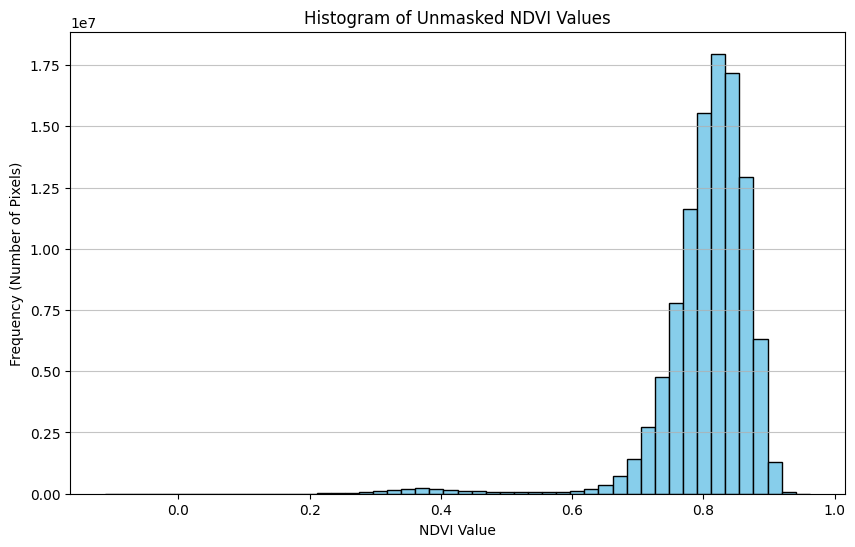

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

if 'ndvi_data' in locals() and ndvi_data is not None:
    unmasked_ndvi_values = ndvi_data[~np.isnan(ndvi_data)]

    plt.figure(figsize=(10, 6))
    plt.hist(unmasked_ndvi_values, bins=50, color='skyblue', edgecolor='black') # Adjust bins as needed
    plt.title("Histogram of Unmasked NDVI Values")
    plt.xlabel("NDVI Value")
    plt.ylabel("Frequency (Number of Pixels)")
    plt.grid(axis='y', alpha=0.75)
    plt.show()
else:
    print("NDVI data not available to generate histogram.")

In [ ]:
# Calculate Area of Each Category on unmasked data

if 'classified_unmasked' in locals() and 'src_ndvi' in locals():
    # Get the resolution (pixel size) from the source NDVI dataset metadata
    pixel_width = abs(src_ndvi.transform[0])
    pixel_height = abs(src_ndvi.transform[4])

    # Calculate the area of a single pixel
    pixel_area = pixel_width * pixel_height

    print(f"\nPixel area: {pixel_area:.4f} square units (based on CRS: {src_ndvi.crs})")

    print("\nArea by Category (Unmasked Data Only):")
    # Define a dictionary to map category IDs to human-readable names
    category_names = {
        1: "Non-Vegetated/Very Low Vigor",
        2: "Sparse/Poor Vegetation",
        3: "Moderate Vegetation",
        4: "Healthy Vegetation",
        5: "Very Healthy/Lush Vegetation"
    }

    # Iterate through the sorted category IDs found in the unmasked data counts
    if 'category_counts_unmasked' in locals():
        for category_id in sorted(category_counts_unmasked.keys()):
            count = category_counts_unmasked[category_id]
            area = count * pixel_area # Area is count of pixels * area of one pixel

            # Get the descriptive name for the category, or a fallback if not found
            name = category_names.get(category_id, f"Unknown Category {int(category_id)}")
            # Print the area. The units are determined by the CRS of the input file.
            # Common units are meters (for projected CRS) or degrees (for geographic CRS).

            print(f"  {name}: {area:.2f} square units")
    else:
        print("Category counts for unmasked data not available.")

else:
    print("Area calculation skipped because classified unmasked data or source NDVI data is not available.")



Pixel area: 0.0018 square units (based on CRS: EPSG:2157)

Area by Category (Unmasked Data Only):
  Non-Vegetated/Very Low Vigor: 10.81 square units
  Sparse/Poor Vegetation: 339.38 square units
  Moderate Vegetation: 3060.79 square units
  Healthy Vegetation: 63555.19 square units
  Very Healthy/Lush Vegetation: 113696.94 square units
